# Automate Gist Creation From Markdown File Using Python

Markdown's code block is great for writing code snippets. However, when you try to publish or share it via blogging platform there are some shortcomings. Gist can help to bridge the gap. Gist makes your blog look better & easier to maintain. In this post, Let us see how automated gist creation can improve your technical blogging experience.

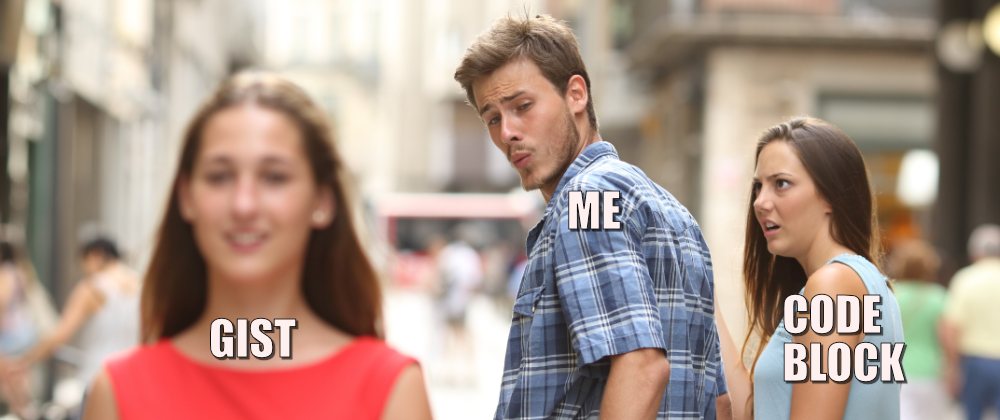

# Gist Intro

Gist is a github repository where you can store & share code/data with others. A single gist can store multiple files. Syntax highlighting is supported based on the file extension type, so be careful when you name the file. Gists can be public or secret. Do note that secret gists aren't private, meaning anyone with the URL would be able to view the code/data. Check out [this post](https://www.liquidweb.com/kb/little-known-ways-to-utilize-github-gists/) for more on gist.

## Why to use gist?

* Supports github repository functionalities like version control, fork & clone.

* Ability to subscribe, star and comment makes gist easy to collaborate with others.

* Gist can be shared in multiple ways without any dependency or installation.

![Gist Share](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/gjgbl522f6qn80nlud9k.png)

# Why use gist in a blog?

My current workflow for blogging is as follows:


1. Use Jupyter notebook to write the blog.
2. Download the notebook as markdown file.
3. Make edits to markdown file before posting to platforms like [Medium](https://6aravind.medium.com) & [Devto](https://dev.to/6aravind)

There are many manual processes involved in step 3, which I'm planning to address in the next few weeks. My biggest concern right now is how the code snippet looks in different platforms. To be more specific:
* No easy way to make changes to code snippets after publishing
* Medium loses syntax highlighting
* Unable to highlight specific lines in a long code snippet in both the platforms

|<center> Medium </center>| <center> Gist </center> |
|:-:|:-:|
|![Medium](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/llo6oottctvi4cqfcuzz.png)|![Gist](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/ep0ep4wuolfadfemlndk.png)|

Gist helps to solve all these issues. Also as a bonus, All code snippets from the same blog can be grouped together via gist. This makes it easier to refer/access (if needed).

# Gist Creation From Markdown File

The goal is to create a gist for the markdown file where every code snippet will be a separate file.

1. First we will download the token for gist creation like mentioned in [this post](https://www.liquidweb.com/kb/little-known-ways-to-utilize-github-gists/) and store it in a file named - *create_gist_token.txt*

In [1]:
# Read Gist Creation Token
from pathlib import Path
tokenFile = Path("create_gist_token.txt")
with open(tokenFile, 'r') as f: token = f.read().strip('\n')

2. We can read the markdown file using python and use regular expression to find all the code blocks. Code block for python is created by wrapping the code between **```python** and **```** in the markdown file. The flag [re.S](https://docs.python.org/3/library/re.html#re.S) makes sure that the matching includes newline as well

In [ ]:
# Read Markdown File and Get Code Snippets

# Import Libraries and Set Variables
import re
PY_CODEBLK_PAT =  '```python\n'
END_CODEBLK_PAT = '```'

# Read the Markdown File
mdFile = 'Sample.md'
with open(mdFile, 'r') as f:
    content = f.read()

# Get all code snippets from the file
def getCodeSnippets(code):
    # Flag re.S searches across mutiple lines
    return re.findall(PY_CODEBLK_PAT + '(.*?)' + END_CODEBLK_PAT, code, re.S)
codeSnippets = getCodeSnippets(content)
nrSnippets = len(codeSnippets)
assert nrSnippets > 0, 'No Code Snippets found!'

3. As mentioned earlier, each code snippet is going to be a separate file in a gist, so we need a name for each one. To keep it simple, we will take the first comment as the name of the file.

In [ ]:
# Get the first comment from code snippet
def getSnippetName(code, ext = ".py"): 
    name = code.split("\n")[0].strip()
    assert name[0] == "#", "Please name the code snippet using '#'"
    return name.strip("#").strip().replace(" ", "_") + ext

# Set the first comment of the code snippet as file name of the snippet
gists = {}
for code in codeSnippets: gists[getSnippetName(code)] = { "content": code }

4. The description of the gist will be the first header of the markdown file. Typically, this will be the name of the blog, so it should be sufficient. Now we can put all the data together and make the API call.

In [ ]:
# Setup data and make api call

# Get the first header of the Markdown file
# This will be set as description of the gist
def getDesc(txt):
    return re.findall(r'#(.*?)\n', txt)[0].strip()

# Set up the data to be uploaded
query_url = "https://api.github.com/gists"
data = {
    "public": True,
    "description": getDesc(content),
    "files": gists
}
headers = {'Authorization': f'token {token}'}

# Send the request
req = requests.post(query_url, headers=headers, data=json.dumps(data))
assert req.ok, 'Github API call failed'

5. As Devto supports liquid text we need special formatting for  gist embedding when compared to Medium. In both the platforms, we need to specify the file so that the entire gist is not displayed. 

In [ ]:
# Gist Embedding

# Get the gist embedding for Medium
def mediumGist(req, file):
    gisturl = req.json()['html_url']
    url = gisturl + '.js?file=' + file
    return url

# Get the liquid text of the gist for Dev Community    
def devGist(req, file, username = GITHUB_ID):
    id = req.json()["id"]
    url = f'gist https://gist.github.com/{username}/{id}'
    return f'{{% {url} file={file} %}}'

6. Loop through all the uploaded files and replace them with corresponding gist embeddings in the markdown file. I have included the embeddings for both the platforms, feel free to modify it as per your needs.

In [ ]:
# Replace the code blocks with corresponding gist in the Markdown file 
updatedContent = content
# Loop through all files
for fileName in list(gists.keys()):
    # Get the content which was uplaoded for this file
    codeSnippet = PY_CODEBLK_PAT + req.json()['files'][fileName]['content'] + END_CODEBLK_PAT
    # Set the link as the combination of DevCommunity & Medium gists
    link = devGist(req, fileName) + "\n\n" + mediumGist(req, fileName)
    # Replace the orginal content with 
    updatedContent = updatedContent.replace(codeSnippet, link)

# Write the updated Markdown file to disk
updateFileName = mdFile.with_name("Gist_" + mdFile.stem + MD_EXT)
with open(updateFileName,'w+') as f:
    f.write(updatedContent)
print(f'Created the file: {updateFileName.name}')

7. Rewiring the script to make it easier to run from command line.

In [ ]:
# Gist Creation From Markdown File

# import libraries
import re
from pathlib import Path
import argparse
import requests
import json

# Set up variables
GIST_TOKEN_PATH = "create_gist_token.txt"
GITHUB_ID = '6aravind'
PY_CODEBLK_PAT =  '```python\n'
END_CODEBLK_PAT = '```'
FILE_EXT = ".py"
MD_EXT = ".md"
MD_FILES = [f for f in Path(".").iterdir() if f.suffix == MD_EXT]


# Read & Parse args
my_parser = argparse.ArgumentParser(prog='gistmark', description='Gist the code blocks in MarkDown file')
my_parser.add_argument('file', action='store', nargs='?', default=MD_FILES[0])
my_parser.add_argument('token', action='store', nargs='?', default=GIST_TOKEN_PATH)
args = my_parser.parse_args()

# Display the file name
mdFile = Path(args.file)
tokenFile = Path(args.token)
print(f'Gisting the file: {mdFile}')

# Read the contents of the file
assert mdFile.is_file(), "Markdown file does not exist"
assert mdFile.suffix == MD_EXT, "Input file must be of extenstion: '.md'"
with open(mdFile, 'r') as f:
    content = f.read()

# Get all code snippets from the file
def getCodeSnippets(code):
    # Flag re.S searches across mutiple lines
    return re.findall(PY_CODEBLK_PAT + '(.*?)' + END_CODEBLK_PAT, code, re.S)
codeSnippets = getCodeSnippets(content)
nrSnippets = len(codeSnippets)
assert nrSnippets > 0, 'No Code Snippets found!'
print(f'{nrSnippets} of code snippets found.')

# Get the first comment from code snippet
def getSnippetName(code, ext = FILE_EXT): 
    name = code.split("\n")[0].strip()
    assert name[0] == "#", "Please name the code snippet using '#'"
    return name.strip("#").strip().replace(" ", "_") + ext

# Set the first comment of the code snippet as file name of the snippet
gists = {}
for code in codeSnippets: gists[getSnippetName(code)] = { "content": code }


# Get the first header of the Markdown file
# This will be set as description of the gist
def getDesc(txt):
    return re.findall(r'#(.*?)\n', txt)[0].strip()

# Get the gist creation token
assert tokenFile.is_file(), "token file does not exist"
with open(tokenFile, 'r') as f: token = f.read().strip('\n')

# Set up the data to be uploaded
query_url = "https://api.github.com/gists"
data = {
    "public": True,
    "description": getDesc(content),
    "files": gists
}
headers = {'Authorization': f'token {token}'}

# Send the request
req = requests.post(query_url, headers=headers, data=json.dumps(data))
assert req.ok, 'Github API call failed'

# Get the gist embedding for Medium
def mediumGist(req, file):
    gisturl = req.json()['html_url']
    url = gisturl + '.js?file=' + file
    return url

# Get the liquid text of the gist for Dev Community    
def devGist(req, file, username = GITHUB_ID):
    id = req.json()["id"]
    url = f'gist https://gist.github.com/{username}/{id}'
    return f'{{% {url} file={file} %}}'

# Replace the code blocks with corresponding gist in the Markdown file 
updatedContent = content
# Loop through all files
for fileName in list(gists.keys()):
    # Get the content which was uplaoded for this file
    codeSnippet = PY_CODEBLK_PAT + req.json()['files'][fileName]['content'] + END_CODEBLK_PAT
    # Set the link as the combination of DevCommunity & Medium gists
    link = devGist(req, fileName) + "\n\n" + mediumGist(req, fileName)
    # Replace the orginal content with 
    updatedContent = updatedContent.replace(codeSnippet, link)

# Write the updated Markdown file to disk
updateFileName = mdFile.with_name("Gist_" + mdFile.stem + MD_EXT)
with open(updateFileName,'w+') as f:
    f.write(updatedContent)
print(f'Created the file: {updateFileName.name}')

# Takeaway

Gist is quite useful and addresses many of the pet peeves in blogging. We have managed to put together a python script which can reduce the manual effort required in publishing a blog. Feel free to reach out to me via [Twitter](https://twitter.com/6aravind) or comments on your thoughts about this post.